<a href="https://colab.research.google.com/github/Yash-Pandey007/Insurance-Claim/blob/main/Insurance_analysis_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# CONFIGURATION
RANDOM_STATE = 42
TEST_SIZE = 0.3
BENCHMARK_CLAIM_RATE = 0.25
INPUT_DATA_FILE = "https://raw.githubusercontent.com/Yash-Pandey007/Insurance-Claim/refs/heads/main/customer-data.csv/customer-data.csv"
OUTPUT_RESULTS_FILE = ".xlsx"

In [33]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

import matplotlib.pyplot as plt

In [34]:
def load_data(path):
    df = pd.read_csv(path)
    return df

df = load_data(INPUT_DATA_FILE)
df.head()

,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True


In [35]:
def preprocess_data(df):

    # Fill missing values
    df['credit_score'] = df['credit_score'].fillna(df['credit_score'].median())
    df['annual_mileage'] = df['annual_mileage'].fillna(df['annual_mileage'].median())

    # Risk behavior score
    df['risk_behavior_score'] = (
        df['speeding_violations']*1.5 +
        df['DUIs']*3 +
        df['past_accidents']*2
    )

    # Encode categoricals
    df = pd.get_dummies(df, drop_first=True)

    # Convert boolean columns to int for statsmodels compatibility
    for col in df.select_dtypes(include='bool').columns:
        df[col] = df[col].astype(int)

    return df

df = preprocess_data(df)
df.head()

,id,credit_score,vehicle_ownership,married,children,postal_code,annual_mileage,speeding_violations,DUIs,past_accidents,outcome,risk_behavior_score,age_26-39,age_40-64,age_65+,gender_male,race_minority,driving_experience_10-19y,driving_experience_20-29y,driving_experience_30y+,education_none,education_university,income_poverty,income_upper class,income_working class,vehicle_year_before 2015,vehicle_type_sports car
0,569520,0.629027,1,0,1,10238,12000.0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,750365,0.357757,0,0,0,10238,16000.0,0,0,0,1,0.0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0
2,199901,0.493146,1,0,0,10238,11000.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,478866,0.206013,1,0,1,32765,11000.0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0
4,731664,0.388366,1,0,0,32765,12000.0,2,0,1,1,5.0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0


In [36]:
def split_data(df, target='outcome'):
    X = df.drop(['id', target], axis=1)
    y = df[target]

    return train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = split_data(df)


In [37]:
def train_logit(X_train, y_train):
    X_train_sm = sm.add_constant(X_train)
    model = sm.Logit(y_train, X_train_sm)
    result = model.fit()
    return result

logit_model = train_logit(X_train, y_train)
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.357324
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6974
Method:                           MLE   Df Model:                           25
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                  0.4256
Time:                        09:09:38   Log-Likelihood:                -2501.3
converged:                       True   LL-Null:                       -4354.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.2504      0.347     -3.609      0.000      -1

In [38]:
def predict_logit(model, X):
    X_sm = sm.add_constant(X)
    return model.predict(X_sm)

logit_pred = predict_logit(logit_model, X_test)


In [39]:
def train_rf(X_train, y_train):
    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE
    )
    rf.fit(X_train, y_train)
    return rf

rf_model = train_rf(X_train, y_train)
rf_pred = rf_model.predict_proba(X_test)[:,1]


In [40]:
logit_auc = roc_auc_score(y_test, logit_pred)
rf_auc = roc_auc_score(y_test, rf_pred)

print("Logit AUC:", logit_auc)
print("Random Forest AUC:", rf_auc)


Logit AUC: 0.9046559522325301
Random Forest AUC: 0.9070084752908774


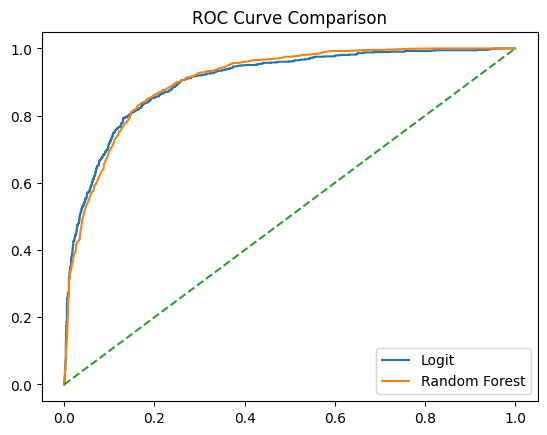

In [41]:
fpr1, tpr1, _ = roc_curve(y_test, logit_pred)
fpr2, tpr2, _ = roc_curve(y_test, rf_pred)

plt.plot(fpr1, tpr1, label='Logit')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()


In [42]:
df['predicted_risk'] = predict_logit(logit_model, df.drop(['id','outcome'], axis=1))

company_claim_rate = df['outcome'].mean()
frequency_index = company_claim_rate / BENCHMARK_CLAIM_RATE

print("Frequency Index:", frequency_index)


Frequency Index: 1.2532


In [43]:
def export_results(df, logit_auc, rf_auc):
    with pd.ExcelWriter(OUTPUT_FILE) as writer:
        df.to_excel(writer, sheet_name='Scored_Data', index=False)

        summary = pd.DataFrame({
            "Metric": ["Logit AUC", "Random Forest AUC", "Claim Rate", "Frequency Index"],
            "Value": [logit_auc, rf_auc, df['outcome'].mean(), frequency_index]
        })

        summary.to_excel(writer, sheet_name='Model_Summary', index=False)

    # Git push
    !git add insurance_model_output.xlsx
    !git commit -m "Update model output"
    !git push